In [1]:
import pandas as pd
import numpy as np
import anndata as ad
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import scipy as sc
from statsmodels.stats.multitest import fdrcorrection
import warnings
warnings.filterwarnings("ignore")

plt.style.use('./plot_script/mplstyle_czi')
import sys
sys.path.insert(0, './plot_script/')
import cziplot
dpi=150

In [2]:
# meta data
cluster_meta=pd.read_csv('../data/TableS7-cell_metadata.csv.gz',index_col=0).dropna()
cluster_meta['age']=cluster_meta['donor'].str[0]
cluster_meta['sex']=cluster_meta['donor'].str[1]
print(cluster_meta.shape)
gene_meta=pd.read_csv('../data/gencode.v37.annotation.intragenic.bed.gz',
                      names=['chr','start','end','gene_id','strand','tmp','gene_name','fn'],
                      index_col='gene_id', sep='\t')
gene_meta['len']=gene_meta['end']-gene_meta['start']
gene_meta=gene_meta[~gene_meta['chr'].isin(['chrY','chrM'])]
genedict_nametoid=dict(zip(gene_meta.gene_name, gene_meta.index))
genedict_idtoname=dict(zip(gene_meta.index, gene_meta.gene_name))
level2_order=cziplot.level2_order
level2_palette=cziplot.level2_palette

(54779, 22)


# cell type composition

,fdr
MGE_SST,0.064784
CGE_LAMP5_LHX6,0.064784
L4-5IT_RORB_ARHGAP15,0.074110
CGE_VIP,0.092516
MGE_PVALB_COL15A1,0.119531
L4-5IT_RORB_LRRK1,0.156134
L6IT_THEMIS_LINC00343,0.178209
L6b_TLE4_NXPH4,0.178209
L6CT_TLE4_FAM95C,0.191574
L4-5IT_RORB_TSHZ2,0.191574


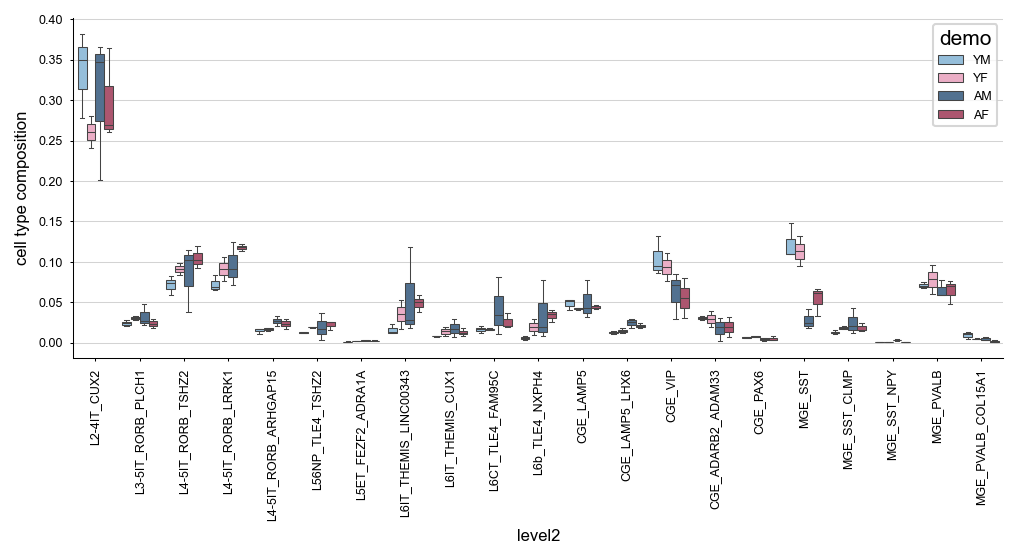

In [3]:
level='level2'
cluster_meta['demo']=cluster_meta['age']+cluster_meta['sex']
celltype_donor_size=cluster_meta[~(cluster_meta[level].str.contains('Glia'))].groupby('donor').size().to_frame('counts')
celltype_donor_size_dic=dict(zip(celltype_donor_size.index, celltype_donor_size.counts))
df=cluster_meta[~(cluster_meta[level].str.contains('Glia'))].groupby(['donor',level,'demo']).size().reset_index()
df.columns=['donor',level,'demo','number']
df['totalcounts']=df['donor'].map(celltype_donor_size_dic)
df['ratio']=df['number']/df['totalcounts']

plt.figure(figsize=(8,3),dpi=dpi)
sns.boxplot(x=level,y='ratio',data=df,hue='demo',hue_order=cziplot.demo_order,order=cziplot.level2_order_full[0:-3],showfliers=False,
              palette=cziplot.demo_palette,
             linewidth=0.5)
plt.xticks(rotation=90)
plt.ylabel('cell type composition')
plt.grid(axis='y')
pall=[]
for i in cziplot.level2_order_full[0:-3]:
    s,p=sc.stats.ranksums(df[(df['demo'].isin(['AM','AF']))&(df[level]==i)]['ratio'],df[(df['demo'].isin(['YM','YF']))&(df[level]==i)]['ratio'])
    pall.append(p)
    if (p < 0.05) & (s<1):
        r=df[(df['demo'].isin(['YM','YF']))&(df[level]==i)]['ratio'].mean()/df[(df['demo'].isin(['AM','AF']))&(df[level]==i)]['ratio'].mean()
    if (p < 0.05) & (s>1):
        r=df[(df['demo'].isin(['AM','AF']))&(df[level]==i)]['ratio'].mean()/df[(df['demo'].isin(['YM','YF']))&(df[level]==i)]['ratio'].mean()
fdr=fdrcorrection(pall,method='poscorr')
pd.DataFrame(index=cziplot.level2_order_full[0:-3],columns=['fdr'],data=fdr[1]).sort_values('fdr')

# global methylation

,p,FDR,sig
L2-4IT_CUX2,0.017622,0.158599,*
L4-5IT_RORB_TSHZ2,0.017622,0.158599,*
L4-5IT_RORB_ARHGAP15,0.067889,0.305501,
MGE_SST,0.067889,0.305501,
CGE_PAX6,0.144127,0.432381,
MGE_SST_CLMP,0.144127,0.432381,
L4-5IT_RORB_LRRK1,0.201243,0.452796,
L6b_TLE4_NXPH4,0.201243,0.452796,
L3-5IT_RORB_PLCH1,0.273322,0.491979,
L6IT_THEMIS_LINC00343,0.273322,0.491979,


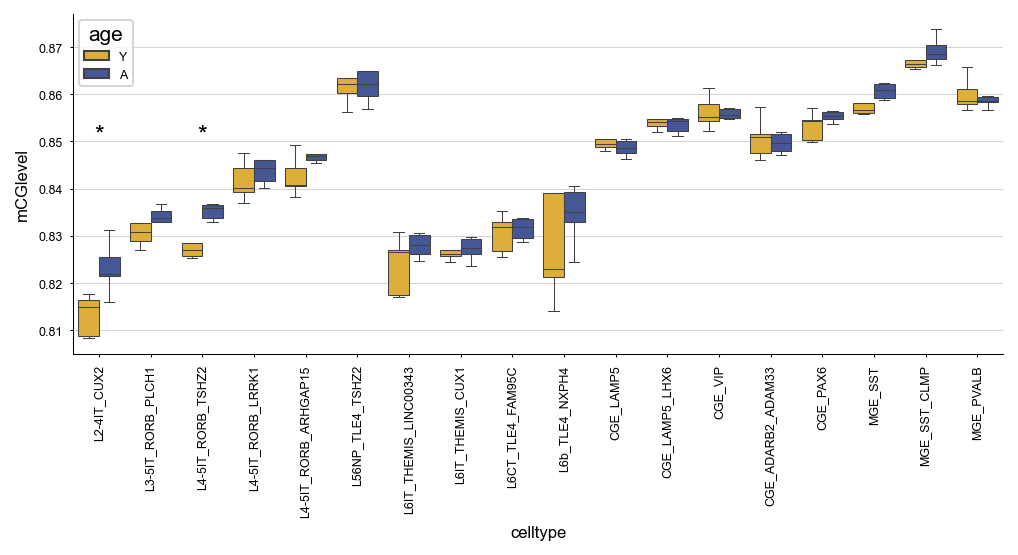

In [4]:
globalm=pd.read_csv('../data/globalMethylation_autosome_rmSNPs.txt.gz',sep='\t',index_col=0)
globalm['celltype']=globalm.index.str.rsplit('-',1).str[0]
globalm['donor']=globalm.index.str.rsplit('-',1).str[1]
globalm['age']=globalm['donor'].str[0] 

plt.figure(figsize=(8,3),dpi=dpi)
ax=sns.boxplot(data=globalm, x="celltype", y="mCGlevel",order=cziplot.level2_order,hue='age',hue_order=['Y','A'],palette=cziplot.age_palette,showfliers=False)
plt.tick_params(axis='x', rotation=90)
plt.grid(axis='y')
df=pd.DataFrame(index=cziplot.level2_order,columns=['p'])
for i in cziplot.level2_order:
    globalm_sub=globalm[globalm['celltype']==i]
    s,p=sc.stats.ranksums(globalm_sub[globalm_sub['age']=='A']['mCGlevel'],globalm_sub[globalm_sub['age']=='Y']['mCGlevel'])
    df.loc[i,'p']=p
_,df['FDR']=fdrcorrection(df['p'], method='indep', is_sorted=False)

df['sig']=''
df.loc[df['FDR']<0.2,'sig']='*'
stat=df['sig']
pos = range(len(stat))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick],
            0.85,
            stat[tick],
            horizontalalignment='center',
            size=12) 
df.sort_values('FDR')

,p,FDR,sig
MGE_SST,0.04461,0.602089,
L4-5IT_RORB_ARHGAP15,0.100348,0.602089,
MGE_SST_CLMP,0.100348,0.602089,
L2-4IT_CUX2,0.201243,0.603728,
L3-5IT_RORB_PLCH1,0.201243,0.603728,
L4-5IT_RORB_TSHZ2,0.144127,0.603728,
CGE_PAX6,0.36131,0.804376,
CGE_ADARB2_ADAM33,0.715001,0.804376,
CGE_VIP,0.465209,0.804376,
CGE_LAMP5_LHX6,0.583882,0.804376,


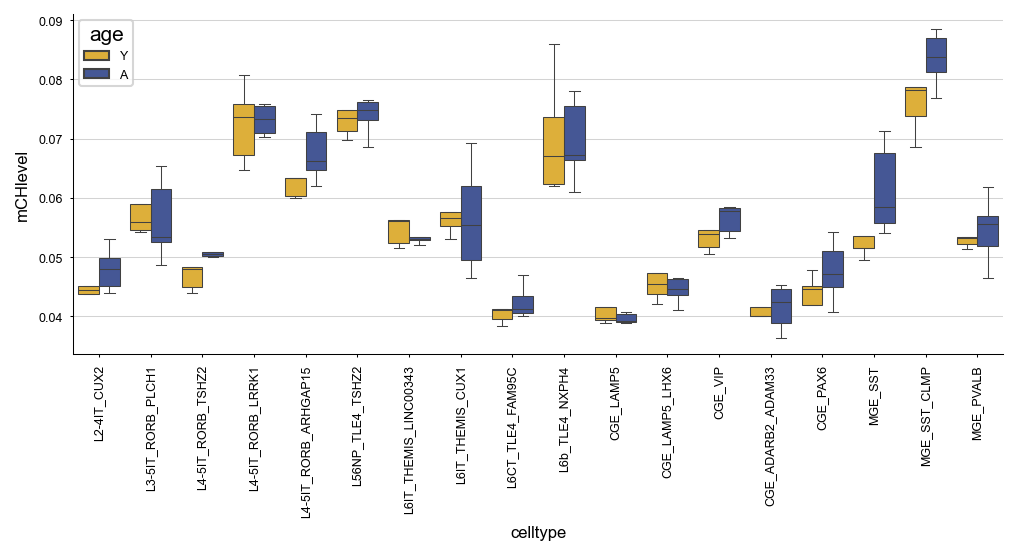

In [5]:
plt.figure(figsize=(8,3),dpi=dpi)
ax=sns.boxplot(data=globalm, x="celltype", y="mCHlevel",order=cziplot.level2_order,hue='age',hue_order=['Y','A'],palette=cziplot.age_palette,showfliers=False)
plt.tick_params(axis='x', rotation=90)
plt.grid(axis='y')
df=pd.DataFrame(index=cziplot.level2_order,columns=['p'])
for i in cziplot.level2_order:
    globalm_sub=globalm[globalm['celltype']==i]
    s,p=sc.stats.ranksums(globalm_sub[globalm_sub['age']=='A']['mCHlevel'],globalm_sub[globalm_sub['age']=='Y']['mCHlevel'])
    df.loc[i,'p']=p
_,df['FDR']=fdrcorrection(df['p'], method='indep', is_sorted=False)

df['sig']=''
df.loc[df['FDR']<0.2,'sig']='*'
stat=df['sig']
pos = range(len(stat))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick],
            0.85,
            stat[tick],
            horizontalalignment='center',
            size=12) 
df.sort_values('FDR')

,p,FDR,sig
MGE_SST,0.04461,0.602089,
L4-5IT_RORB_ARHGAP15,0.100348,0.602089,
MGE_SST_CLMP,0.100348,0.602089,
L2-4IT_CUX2,0.201243,0.603728,
L3-5IT_RORB_PLCH1,0.201243,0.603728,
L4-5IT_RORB_TSHZ2,0.144127,0.603728,
CGE_PAX6,0.36131,0.804376,
CGE_ADARB2_ADAM33,0.715001,0.804376,
CGE_VIP,0.465209,0.804376,
CGE_LAMP5_LHX6,0.583882,0.804376,


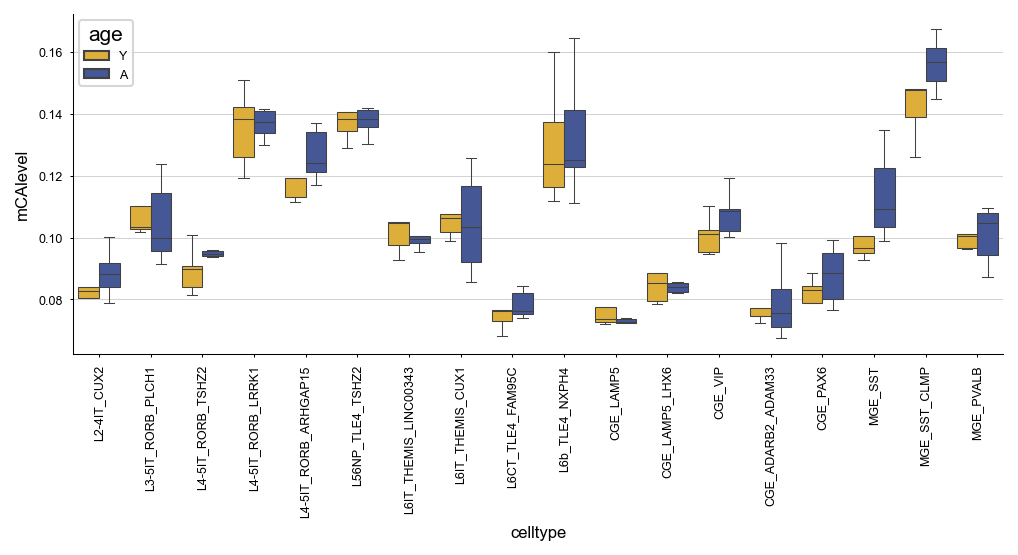

In [6]:
plt.figure(figsize=(8,3),dpi=dpi)
ax=sns.boxplot(data=globalm, x="celltype", y="mCAlevel",order=cziplot.level2_order,hue='age',hue_order=['Y','A'],palette=cziplot.age_palette,showfliers=False)
plt.tick_params(axis='x', rotation=90)
plt.grid(axis='y')
df=pd.DataFrame(index=cziplot.level2_order,columns=['p'])
for i in cziplot.level2_order:
    globalm_sub=globalm[globalm['celltype']==i]
    s,p=sc.stats.ranksums(globalm_sub[globalm_sub['age']=='A']['mCHlevel'],globalm_sub[globalm_sub['age']=='Y']['mCHlevel'])
    df.loc[i,'p']=p
_,df['FDR']=fdrcorrection(df['p'], method='indep', is_sorted=False)

df['sig']=''
df.loc[df['FDR']<0.2,'sig']='*'
stat=df['sig']
pos = range(len(stat))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick],
            0.85,
            stat[tick],
            horizontalalignment='center',
            size=12) 
df.sort_values('FDR')

# compare with GTEx

In [7]:
! wget -O /scratch/Dong_Cell2021_ageDEGs.xlsx https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8208793/bin/ACEL-20-e13357-s002.xlsx  --no-check-certificate

--2024-03-19 22:14:55--  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8208793/bin/ACEL-20-e13357-s002.xlsx
Resolving webproxy.ucsd.edu (webproxy.ucsd.edu)... 132.239.1.230, 132.239.1.231
Connecting to webproxy.ucsd.edu (webproxy.ucsd.edu)|132.239.1.230|:3128... connected.
  Self-signed certificate encountered.
Proxy request sent, awaiting response... 200 OK
Length: 3461293 (3.3M) [application/vnd.openxmlformats-officedocument.spreadsheetml.sheet]
Saving to: ‘/scratch/Dong_Cell2021_ageDEGs.xlsx’

/scratch/Dong_Cell2 100%[===================>]   3.30M  4.32MB/s    in 0.8s    

2024-03-19 22:14:56 (4.32 MB/s) - ‘/scratch/Dong_Cell2021_ageDEGs.xlsx’ saved [3461293/3461293]



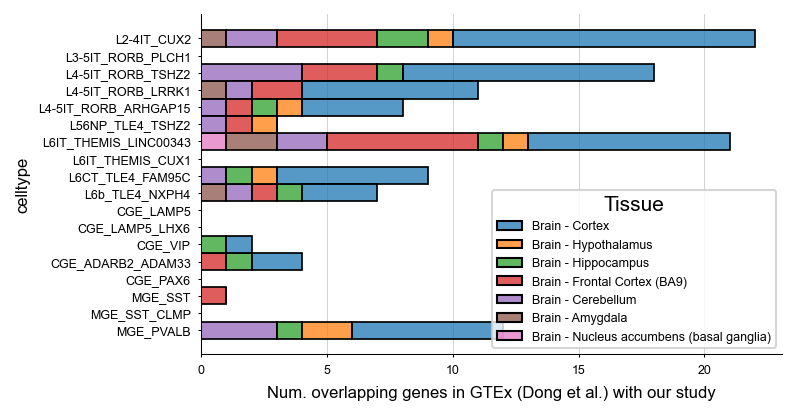

In [9]:
# DEs
fcthres=np.log2(1.2)
pthres=0.05

fulldata=pd.read_csv('../data/ageDEall.tsv.gz',sep='\t',index_col=0)
fulldata=fulldata[fulldata['celltype'].isin(cziplot.level2_order)]
data=fulldata[(fulldata['adj.P.Val']<pthres) & (np.abs(fulldata['logFC'])>fcthres)]

gtex=pd.read_excel('/scratch/Dong_Cell2021_ageDEGs.xlsx',sheet_name='Table S1',skiprows=1)
gtex_age_degs = gtex.merge(data,left_on='Gene name',right_on='gene_name')
gtex_age_degs['RNA logFC sign']=(gtex_age_degs['logFC']>0).map({True:'Up-regulated',False:'Down-regulated'})

df_show = gtex_age_degs[(gtex_age_degs['Tissue'].str.contains('Brain'))&~(gtex_age_degs['Tissue'].str.contains('Hemisphere'))]
df_show['celltype']=df_show['celltype'].astype('category')
df_show['celltype'] = pd.Categorical(df_show['celltype'],categories=cziplot.level2_order,ordered=True)

fig=plt.figure(figsize=(5,3),dpi=dpi)
ax=sns.histplot(df_show,y='celltype',hue='Tissue',multiple='stack')
ax.set_xlabel('Num. overlapping genes in GTEx (Dong et al.) with our study')
ax.grid(axis='x')